# SURE 2024 Speedy Simulations Kickoff
## Kernel Density Estimation with Quasi-Monte Carlo Methods

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### If you are running this on colab, run this cell

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install qmcpy

### Import needed packages

In [14]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Examples of ways to spread points on a hypercube

### Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly

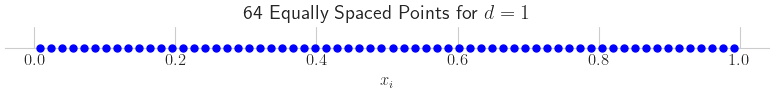

In [15]:
n = 64
xpts = np.linspace(1/(2*n), 1-1/(2*n), n) #equally spaced points between 0 and 1
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), 'b.', markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt)

### Grids in dimension $d$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

In [16]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = ''):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False) 
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt)


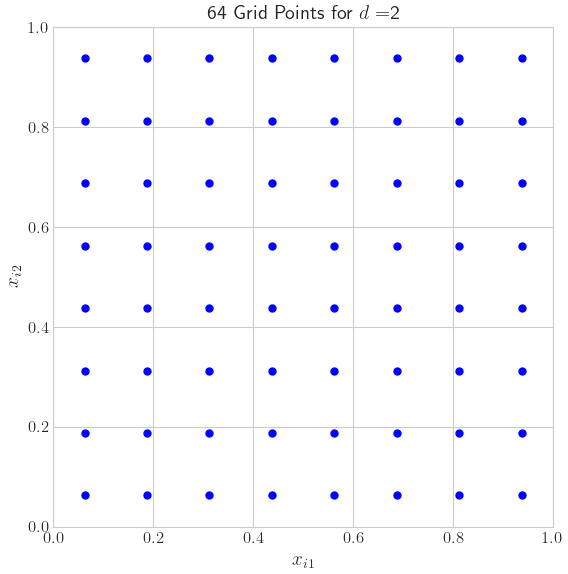

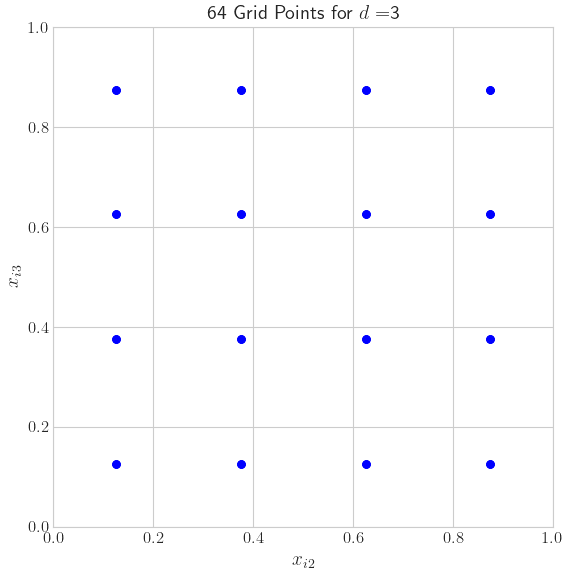

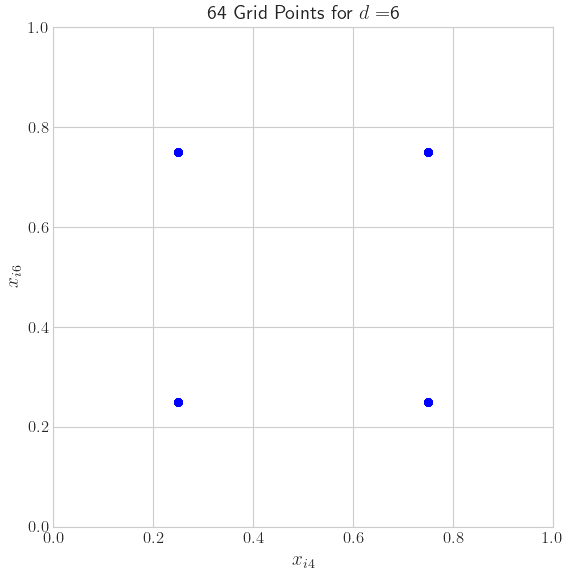

In [17]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [2,3], savefigs, figpath)
plot_grid(make_grid(6,2), [4,6], savefigs, figpath)

### Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

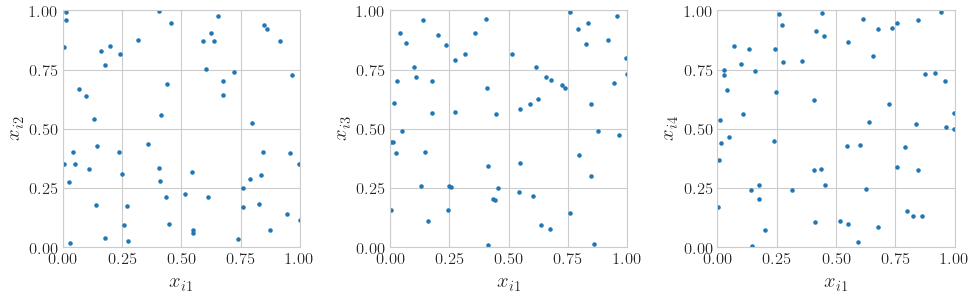

In [18]:
d = 6  #the dimension used for these examples
n = 64  #the sample size used for these examples
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Low disrepancy points
There are several kinds of low discrepancy points, includng Sobol', lattice, and Halton.  Below we display one kind.

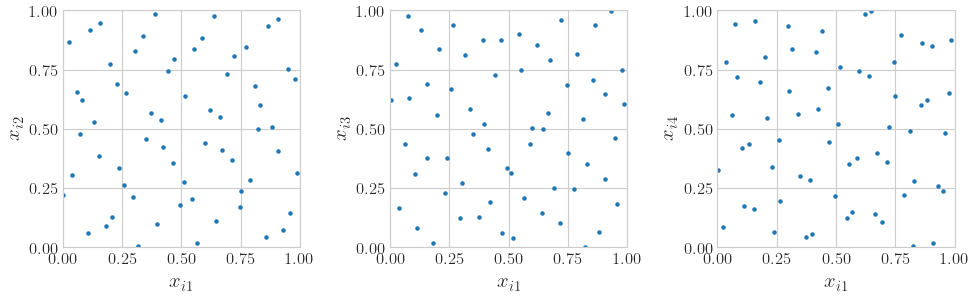

In [19]:
fig,ax = qp.plot_proj(qp.Sobol(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Kernel Density Estimation

### Gaussian kernel

In [20]:
def kernel(y):
    return np.exp(-y*y)/np.sqrt(np.pi)

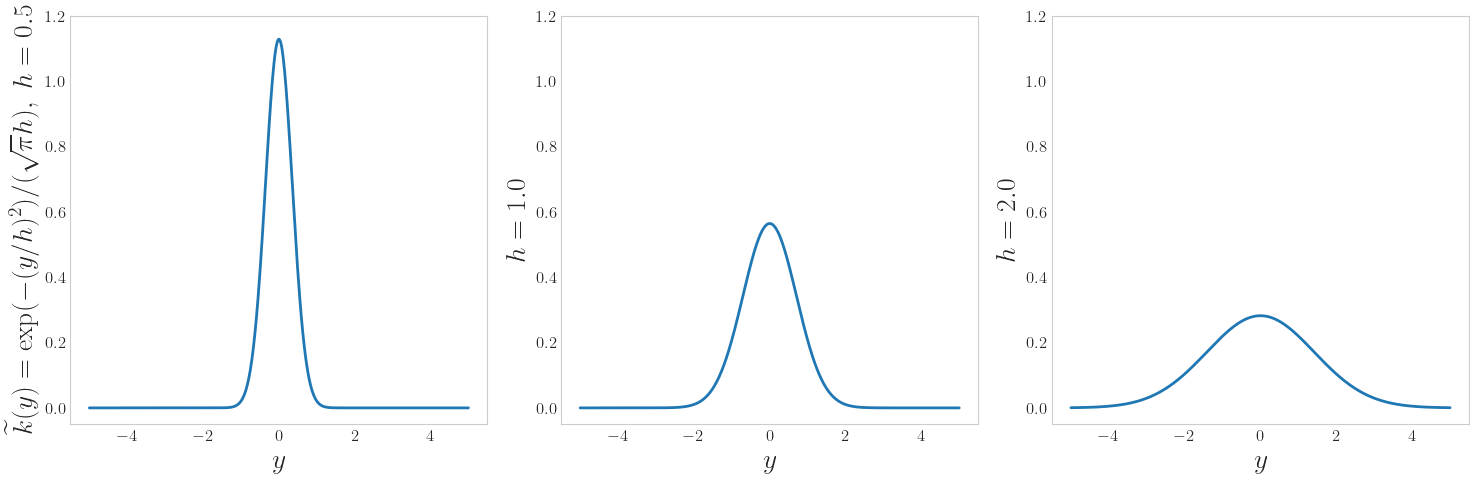

In [27]:
ypts = np.linspace(-5,5,500)
bandwidth = [0.5, 1, 2]
nband = len(bandwidth)
fig,ax = plt.subplots(1,3,figsize=(5*nband,5))
for ii in range(nband):
    ax[ii].plot(ypts,kernel(ypts/bandwidth[ii])/bandwidth[ii])
    ax[ii].grid(False)
    ax[ii].set_ylim([-0.05, 1.2])
    ax[ii].set_xlabel(r'$y$',fontsize=20)
    if (ii == 0):
        ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidth[ii],fontsize=20)
    else:
        ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidth[ii],fontsize=20)
if savefigs:
        fig.savefig(figpath+"kernel."+imgfrmt,format=imgfrmt)

### Numerical experiment

#### Generate some $\vx_i$

In [22]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

iid pts [[0.46384472 0.40501511 0.48048212]
 [0.42147135 0.59373637 0.49796673]
 [0.42507477 0.88047498 0.94991395]
 ...
 [0.21791329 0.14802829 0.92964821]
 [0.84421641 0.69366577 0.4928191 ]
 [0.65318056 0.05906297 0.95839135]]
[[0.46384472 0.20250756 0.12012053]
 [0.42147135 0.29686819 0.12449168]
 [0.42507477 0.44023749 0.23747849]
 ...
 [0.21791329 0.07401414 0.23241205]
 [0.84421641 0.34683288 0.12320478]
 [0.65318056 0.02953149 0.23959784]]
sobol pts [[0.00483778 0.84965692 0.44985498]
 [0.71668113 0.38838746 0.71046488]
 [0.4111282  0.20091931 0.86905514]
 ...
 [0.61473968 0.17134616 0.86943671]
 [0.26208954 0.4838787  0.70715359]
 [0.95845286 0.75465731 0.45215895]]


#### Generate some $y_i=f(x_i)$ points
$
f(\vx) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [23]:
def testfun(x,coord_wts = 1):
    wtx = np.multiply(x,coord_wts)
    y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    #y = x[:,0]
    return y

In [24]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

#### Construct a kernel density estimator

In [25]:
def kde(kernel,ypts,bandwidth,yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval)
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts)/bandwidth))/bandwidth
    return rhoval

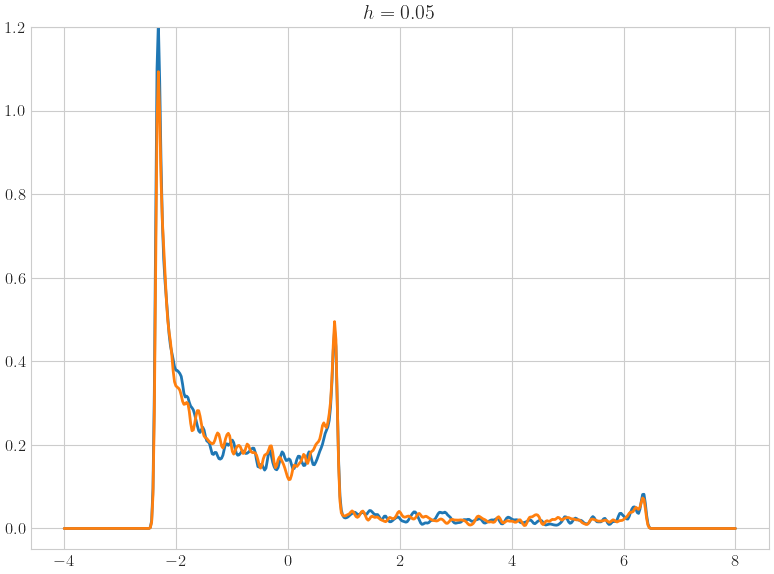

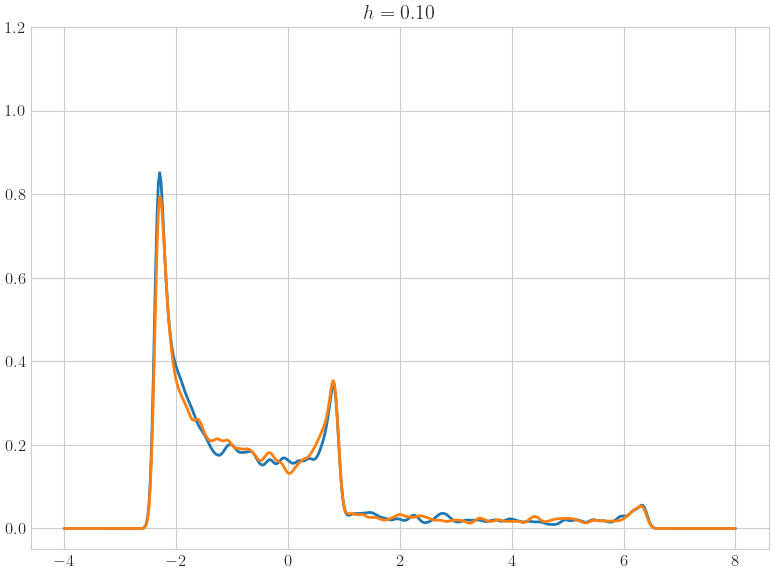

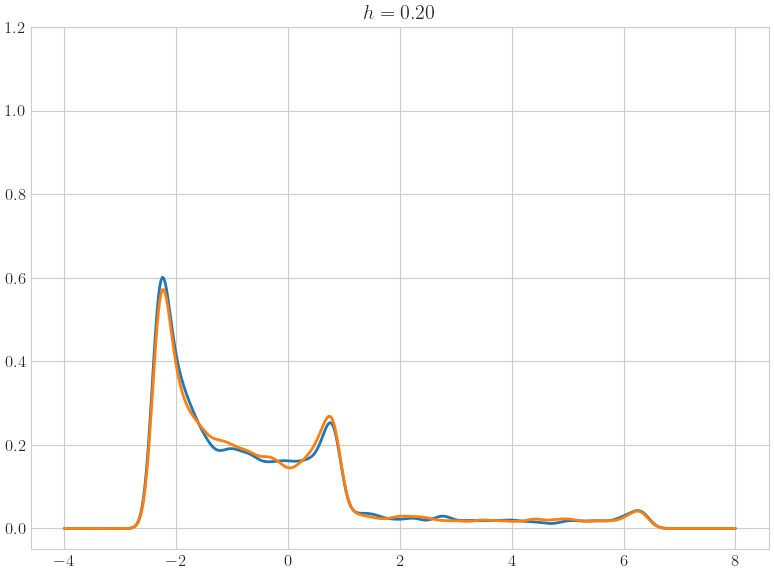

In [26]:
bandwidth = [0.05, 0.1, 0.2]
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid)
    ax.plot(yeval,rhovalsob)
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)